# Import modules

In [26]:
import networkx as nx
import graph_tool.all as gt
# from graph_tool.all import vertex_percolation

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
sns.set_style("dark")
sns.set_style("whitegrid")
%matplotlib inline

---
# Data

In [2]:
raw_data_gml = "./dataset/as-22july06.gml"
network_name = "as-22july06"

data_gml = "./dataset/as-22july06-new.gml"

# Function

# Task

---
### Preprocessing

In [3]:
import subprocess
subprocess.call("sed 'N;s/\s\+\[/ \[/g;P;D' <"+ raw_data_gml + " >"+ data_gml, shell=True)

0

In [4]:
# Load network for networkx
G = nx.read_gml(data_gml)
node_list = G.nodes()
edge_list = G.edges()

# Load network for graph_tool
g = gt.load_graph(data_gml)

In [5]:
# Network properties
print "Network name: " + network_name
print "Type: " + ("Directed" if nx.is_directed(G) else "Undirected")
print "Nodes:", len(node_list)
print "Edges:", len(edge_list)

Network name: as-22july06
Type: Undirected
Nodes: 22963
Edges: 48436


In [6]:
# # Network statistics
# nx.density(G)
# nx.average_clustering(G, trials=1000)

---
### 1. Percolation with uniform removal of nodes

In [38]:
random_removal_list = list(g.vertices())
repeat = 20
sizes_list = [] # To store the sizes of every simulation

for _ in range(repeat):
    np.random.shuffle(random_removal_list)
    sizes, comp = gt.vertex_percolation(g, random_removal_list)
    sizes_list.append(sizes)
    
average_sizes = np.mean(sizes_list,axis=0)

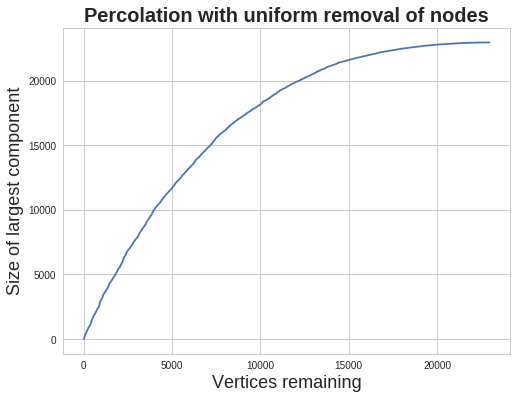

In [39]:
plt.figure(figsize=(8,6))
plt.plot(average_sizes)
plt.title("Percolation with uniform removal of nodes", fontsize=20, fontweight='bold')
plt.xlabel("Vertices remaining", fontsize=18)
plt.ylabel("Size of largest component", fontsize=18)

---
### Percolation with non-uniform removal

In [46]:
targeted_removal_list = sorted([v for v in g.vertices()], key=lambda v: v.out_degree())
repeat = 20
sizes_list2 = [] # To store the sizes of every simulation

for _ in range(repeat):
    sizes2, comp = gt.vertex_percolation(g, targeted_removal_list)
    sizes_list2.append(sizes2)
    
average_sizes2 = np.mean(sizes_list2,axis=0)

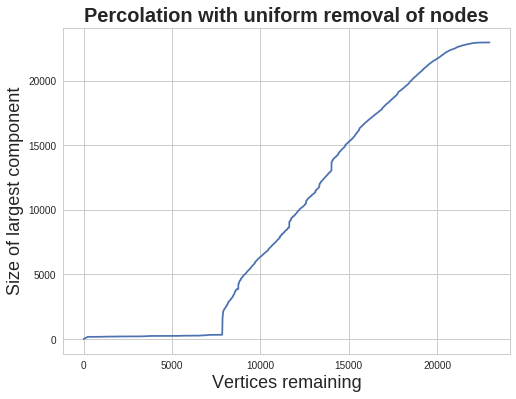

In [47]:
plt.figure(figsize=(8,6))
plt.plot(average_sizes2)
plt.title("Percolation with uniform removal of nodes", fontsize=20, fontweight='bold')
plt.xlabel("Vertices remaining", fontsize=18)
plt.ylabel("Size of largest component", fontsize=18)

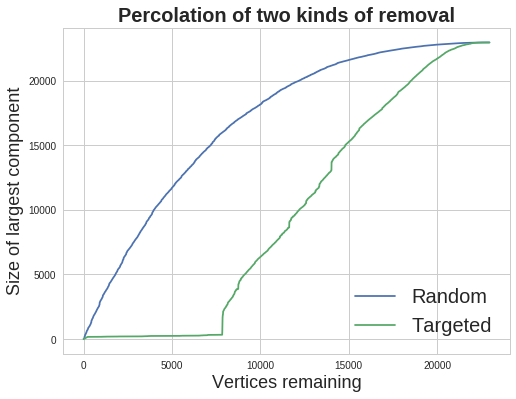

In [58]:
plt.figure(figsize=(8,6))
plt.plot(average_sizes, label="Random")
plt.plot(average_sizes2, label="Targeted")
plt.title("Percolation of two kinds of removal", fontsize=20, fontweight='bold')
plt.xlabel("Vertices remaining", fontsize=18)
plt.ylabel("Size of largest component", fontsize=18)
plt.legend(loc="lower right",prop={'size':20})

---
### 

In [35]:
a = [[2,4,6],[6,4,2]]

np.mean(a,axis=0)

array([ 4.,  4.,  4.])